In [1]:
from packages import *
import random, concurrent.futures, numpy as np, matplotlib.pyplot as plt
from PIL import Image 
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from collections import Counter
%load_ext autoreload
%autoreload 2

In [2]:
# defaults for matplotlib plots
plt.rcParams['figure.figsize'] = def_size = [6.0, 6.0]
plt.rcParams['font.size'] = def_font = 10.0

In [3]:
NUM_SPLITS = 10
NUM_WORKERS = 20

# Preprocessing
Now that we have a intuitive way of accessing the images and their labels, we can go ahead and start the preprocessing pipeline.
## Goals:
* construct dataset
    * fix the dimensions to VGG input layer
    * normalize w.r.t. VGG initialization
    * dump the dataset for persistence

Let's begin by loading the actual images using the link dictionaries we created. For benchmarking purposes, we will also load the partition for the train/val/test splits.

In [4]:
partition = {}
with open(os.path.join(DATA_DIR, 'DeepFashion', 'eval', 'list_eval_partition.txt'), 'r') as f:
    for l in f.readlines()[2:]:
        l = l.strip()
        split = l[71:].strip()
        _, folder, img_name = l[:71].strip().split('/')
        if folder not in partition:
            partition[folder] = {}
        partition[folder][img_name] = split

In [5]:
splits = []
for i in partition:
    for j in partition[i]:
        splits.append(partition[i][j]) 
c = Counter(splits)
print(c)
total = np.sum(list(c.values()))
print('total: {}'.format(total))
print('train: {:.2f}%, val: {:.2f}%, test: {:.2f}%'.format(100*c['train']/total, 100*c['val']/total, 100*c['test']/total))

Counter({'train': 209222, 'val': 40000, 'test': 40000})
total: 289222
train: 72.34%, val: 13.83%, test: 13.83%


In [6]:
# save_pickle(partition, os.path.join(LINK_DIR, 'partition.pkl'))

## Loading the images
We will be loading the images for demonstration purposes, apply the normalization steps and explore data augmentations possibilities. For note, we will be using channel-last format. (H, W, C)

First, we need to fix the dimensions of all of our images to (299, 299, 3) which is what the pre-trained Inception-v4 model expects.

In [7]:
def fix_dimensions(x, dim):
    h, w, _ = x.shape
    if h < dim and w < dim:
        diff = dim - h
        h_beg = diff // 2
        h_end = diff - h_beg
        new_x = np.zeros((dim, w, 3))
        new_x[h_beg: -h_end:, :, :] = x
        new_x[0:h_beg, :, :] = np.expand_dims(np.mean(x[0:5, : :], axis=0), 0)
        new_x[-h_end:, :, :] = np.expand_dims(np.mean(x[-5:, :, :], axis=0 ), 0)
        return fix_dimensions(new_x, dim)
    elif h == dim and w < dim:
        diff = dim - w
        w_beg = diff//2
        w_end = diff - w_beg
        new_x = np.zeros((h, dim, 3))
        new_x[:, w_beg:-w_end, :] = x
        new_x[:,0: w_beg, :] = np.expand_dims(np.mean(x[:, 0:5, :], axis=1), 1)
        new_x[:, -w_end:, :] = np.expand_dims(np.mean(x[:, -5:, :],axis=1), 1)
    elif h < dim and w == dim:
        diff = dim - h
        h_beg = diff // 2
        h_end = diff - h_beg
        new_x = np.zeros((dim, w, 3))
        new_x[h_beg: -h_end:, :, :] = x
        new_x[0:h_beg, :, :] = np.expand_dims(np.mean(x[0:5, : :], axis=0), 0)
        new_x[-h_end:, :, :] = np.expand_dims(np.mean(x[-5:, :, :], axis=0 ), 0)
    else:
        new_x = x
    return new_x

`` load_preprocess_img `` takes care of the loading and calling necessary functions needed in the preprocessing.

In [8]:
def load_preprocess_img(img_path):
    img = np.asarray(Image.open(img_path))[:-5, :-5, :] #some data is actually larger than 300...
    return fix_dimensions(preprocess_input(img), dim=299)

`collapse_dict ` is here because earlier I had chose to maintain the folder structure of the images in my link dictionaries. We will no longer be needing those, so we can collapse that hierearchy.

In [9]:
def collapse_dict(lookup, img_dir=None):
    new_lookup = {}
    if img_dir is None:
        for folder in lookup:
            for img_name in lookup[folder]:
                new_lookup['/'.join([folder,img_name])] = lookup[folder][img_name]
    else:
        for folder in lookup:
            for img_name in lookup[folder]:
                new_lookup['/'.join([img_dir,folder,img_name])] = lookup[folder][img_name]
        
    return new_lookup

In [10]:
img_attr = collapse_dict(load_pickle(os.path.join(LINK_DIR, 'img_attr.pkl')), IMG_DIR)
img_cat = collapse_dict(load_pickle(os.path.join(LINK_DIR, 'img_cat.pkl')), IMG_DIR)
cat_types_inv = load_pickle(os.path.join(LINK_DIR, 'cat_types_inv.pkl'))
partition = collapse_dict(partition, IMG_DIR)

` load_deepfashion ` creates a datapoint from an image and its labels.

In [11]:
def load_deepfashion(img_path, partition_lookup=partition, attr_lookup=img_attr, 
                     cat_lookup=img_cat, cat_type_lookup=cat_types_inv):
    x = load_preprocess_img(img_path).astype(np.float16) #will be using RTX2070 which supports f16
    attr = (attr_lookup[img_path]>0).astype(np.int8) #transform the -1 +1 labeling to one-hot
    cat = cat_lookup[img_path]
    cat_type = cat_type_lookup[cat]
    return x, attr, cat, cat_type

` export_dataset ` automates the whole process and exports the datasets into their respective `train, val, test ` directories. A number of splits is used in order to make smaller chunks of data availabe for later use and avoid loading the whole dataset into RAM, which does not fit in my computer. 

In [14]:
def export_dataset(dataset_dir, split, num_splits = NUM_SPLITS):
    for i in range(num_splits):
        chunk = split[i: i+len(split)//num_splits]
        with concurrent.futures.ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
            dataset = executor.map(load_deepfashion, chunk)
        dataset = [d for d in dataset]
        x, attr, cat, cat_type = [], [], [], []
        for d in dataset:
            assert d[0].shape == (299, 299, 3), d[0].shape
            x.append(d[0])
            attr.append(d[1])
            cat.append(d[2])
            cat_type.append(d[3])
        np.save(os.path.join(dataset_dir, 'X', 'x_{}.npy'.format(i+1)), np.array(x), 
                fix_imports=False, allow_pickle=False)
        np.save(os.path.join(dataset_dir, 'attr', 'attr_{}.npy'.format(i+1)), np.array(attr),
                fix_imports=False, allow_pickle=False)
        np.save(os.path.join(dataset_dir, 'cat', 'cat_{}.npy'.format(i+1)), np.array(cat),
                fix_imports=False, allow_pickle=False)
        np.save(os.path.join(dataset_dir, 'cat_type', 'cat_type_{}.npy'.format(i+1)), np.array(cat_type),
                fix_imports=False, allow_pickle=False)
        print('{}-done'.format(i+1), end=', ')

Now that we have everything in place, we can start exporting the dataset!

In [13]:
paths = {}
paths['train'] = [f for f in list(partition.keys()) if partition[f] == 'train']
paths['val'] = [f for f in list(partition.keys()) if partition[f] == 'val']
paths['test'] = [f for f in list(partition.keys()) if partition[f] == 'test']
random.shuffle(paths['train'])
random.shuffle(paths['val'])
random.shuffle(paths['test'])

In [15]:
for split in paths:
    print('began {} data'.format(split))
    export_dataset(os.path.join(DATASET_DIR, split), paths[split])
    print('finished {} data'.format(split))
    print('************************')

began train data
{}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, finished train data
************************
began val data
{}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, finished val data
************************
began test data
{}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, {}-done, finished test data
************************


## Checking everything worked out fine
Let's print some examples from the dataset now to confirm everything worked out fine!

In [28]:
attr = load_pickle(os.path.join(LINK_DIR, 'attr.pkl'))
cat = load_pickle(os.path.join(LINK_DIR, 'cat.pkl'))
cat_types = load_pickle(os.path.join(LINK_DIR, 'cat_types_str.pkl'))

Pick a random split to import. (train takes a longer time so I took it out)

In [25]:
split = random.choice(['val', 'test'])
i = random.randint(1, NUM_SPLITS)
print('{}, {}'.format(split, i))

val, 3


In [29]:
check_x = np.load(os.path.join(DATASET_DIR, split, 'X', 'x_{}.npy'.format(i)))
check_attr = np.load(os.path.join(DATASET_DIR, split, 'attr', 'attr_{}.npy'.format(i)))
check_cat = np.load(os.path.join(DATASET_DIR, split, 'cat', 'cat_{}.npy'.format(i)))
check_cat_type = np.load(os.path.join(DATASET_DIR, split, 
                                      'cat_type', 'cat_type_{}.npy'.format(i)))

W0517 15:26:46.116734 140260802459456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


upper
Blazer
['boyfriend' 'leather' 'red' 'relaxed' 'tweed']


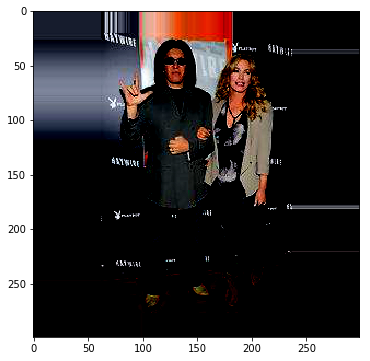

In [41]:
j = random.randint(0, len(check_x))
print(cat_types[check_cat_type[j]])
print(cat[check_cat[j]])
print(attr[np.where(check_attr[j]==1)])
plt.imshow(check_x[j].astype(np.float32))